In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [0]:
# Imports I may use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Kaggle url
#https://www.kaggle.com/grebublin/coronavirus-latlon-dataset

In [4]:
# Upload my file
from google.colab import files
uploaded = files.upload()

Saving coronavirus_cleaned_21Jan2Feb.csv to coronavirus_cleaned_21Jan2Feb.csv


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['coronavirus_cleaned_21Jan2Feb.csv']))

In [6]:
# Looking at the whole dataset
df

,Unnamed: 0,Province/State,Country/Region,Last Update,Confirmed,Suspected,Recovered,Death,lat,lon
0,0,Hubei,China,2020-02-01 23:33:00,9074.0,0.0,215.0,294.0,30.737812,112.238402
1,1,Zhejiang,China,2020-02-02 02:13:00,661.0,0.0,23.0,0.0,29.141643,119.788925
2,2,Guangdong,China,2020-02-02 01:23:00,604.0,0.0,14.0,0.0,23.379033,113.763283
3,3,Henan,China,2020-02-02 00:53:00,493.0,0.0,4.0,2.0,34.290430,113.382354
4,4,Hunan,China,2020-02-02 01:53:00,463.0,0.0,8.0,0.0,27.625300,111.856859
...,...,...,...,...,...,...,...,...,...,...
1318,1318,Heilongjiang,China,2020-01-21 00:00:00,0.0,1.0,0.0,0.0,47.121647,128.738231
1319,1319,0,Japan,2020-01-21 00:00:00,1.0,0.0,0.0,0.0,36.204824,138.252924
1320,1320,0,Thailand,2020-01-21 00:00:00,2.0,0.0,0.0,0.0,15.870032,100.992541
1321,1321,0,South Korea,2020-01-21 00:00:00,1.0,0.0,0.0,0.0,35.907757,127.766922


In [0]:
# Get rid of unamed column
df = df.drop(columns=['Unnamed: 0', 'Last Update'])

In [8]:
# Check dataset again 
df

,Province/State,Country/Region,Confirmed,Suspected,Recovered,Death,lat,lon
0,Hubei,China,9074.0,0.0,215.0,294.0,30.737812,112.238402
1,Zhejiang,China,661.0,0.0,23.0,0.0,29.141643,119.788925
2,Guangdong,China,604.0,0.0,14.0,0.0,23.379033,113.763283
3,Henan,China,493.0,0.0,4.0,2.0,34.290430,113.382354
4,Hunan,China,463.0,0.0,8.0,0.0,27.625300,111.856859
...,...,...,...,...,...,...,...,...
1318,Heilongjiang,China,0.0,1.0,0.0,0.0,47.121647,128.738231
1319,0,Japan,1.0,0.0,0.0,0.0,36.204824,138.252924
1320,0,Thailand,2.0,0.0,0.0,0.0,15.870032,100.992541
1321,0,South Korea,1.0,0.0,0.0,0.0,35.907757,127.766922


In [9]:
# Using .describe() on the whole dataframe
df.describe()

,Confirmed,Suspected,Recovered,Death,lat,lon
count,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000
mean,104.102797,1.504157,2.189720,2.341648,29.544773,87.026884
std,564.540640,13.584017,13.096274,19.658345,16.337593,67.077857
min,0.000000,0.000000,0.000000,0.000000,-37.471308,-127.647621
25%,2.000000,0.000000,0.000000,0.000000,23.697810,101.343106
50%,8.000000,0.000000,0.000000,0.000000,31.230416,111.856859
75%,47.000000,0.000000,0.000000,0.000000,37.895659,117.924900
max,9074.000000,244.000000,215.000000,294.000000,61.924110,146.921099


In [10]:
df.columns

Index(['Province/State', 'Country/Region', 'Confirmed', 'Suspected',
       'Recovered', 'Death', 'lat', 'lon'],
      dtype='object')

In [21]:
# Creating baselines
# Imports
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Getting the Mean Absolute Error for my baseline
baseline = df['Recovered']
average = baseline.mean()
baseline_test = [average] * len(baseline)
mae = mean_absolute_error(baseline, baseline_test)

# Getting the r^2 score for my baseline
baseline_r2_score = r2_score(baseline, baseline_test)
print(f'The Mean Absolute Error is: {mae:.2f} and the R^2 Score is: {baseline_r2_score}')

The Mean Absolute Error is: 3.54 and the R^2 Score is: 0.0


In [23]:
# Splitting my data
from sklearn.model_selection import train_test_split

# Setting my target on recovered
target = 'Recovered'

x_train = df.drop(columns=['Recovered'])
y_train = df['Recovered']

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.20, random_state = 42)

# Check my shapes
print(f'x_train shape is: {x_train.shape}, x_test shape is: {x_test.shape}, y_train shape is: {y_train.shape}, and y_test shape is: {y_test.shape}')

x_train shape is: (1058, 7), x_test shape is: (265, 7), y_train shape is: (1058,), and y_test shape is: (265,)


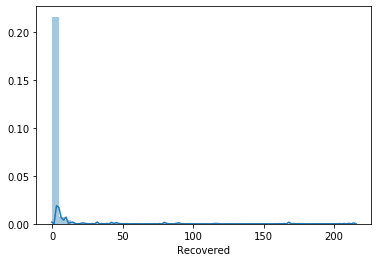

In [24]:
# The target is very skewed
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

In [25]:
# Notes on why I am not stratifying my data. 
# It is normally used to make sure that the train and test sets have the same percentage of samples of each target class as the complete set.
# My train test split will not work when sratified but I have yet to discover the reason.
# I want to see how not using stratify will affect my models.

df['Recovered'].value_counts()

0.0      996
1.0      122
2.0       66
3.0       32
5.0       26
4.0       20
9.0        9
10.0       6
14.0       5
7.0        5
6.0        4
8.0        3
80.0       3
45.0       2
90.0       2
11.0       2
42.0       2
21.0       2
168.0      2
32.0       2
31.0       2
23.0       1
141.0      1
169.0      1
116.0      1
88.0       1
52.0       1
47.0       1
44.0       1
28.0       1
215.0      1
Name: Recovered, dtype: int64

In [26]:
df.dtypes

Province/State     object
Country/Region     object
Confirmed         float64
Suspected         float64
Recovered         float64
Death             float64
lat               float64
lon               float64
dtype: object

In [27]:
# Imports
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# Make pipeline for a Linear model
lr_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    LinearRegression()
)

# Fit on train
lr_pipeline.fit(x_train, y_train)

# Predict on test
y_pred = lr_pipeline.predict(x_test)

# Getting the Mean Absolute Error for my linear
lr_mae = mean_absolute_error(y_test, y_pred)

# Getting the r^2 score for my random forest model
lr_r2_score = r2_score(y_test, y_pred)

print(f'The Mean Absolute Error is: {lr_mae:.2f} and the R^2 Score is: {lr_r2_score}')

The Mean Absolute Error is: 0.83 and the R^2 Score is: 0.9784662971600079


In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

# Make pipeline for a random forest regressor
rf_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train
rf_pipeline.fit(x_train, y_train)

# Check my accuracy score for test
y_pred = rf_pipeline.predict(x_test)

In [29]:
# Getting the Mean Absolute Error for my random forest model
rf_mae = mean_absolute_error(y_test, y_pred)

# Getting the r^2 score for my random forest model
rf_r2_score = r2_score(y_test, y_pred)

print(f'The Mean Absolute Error is: {rf_mae:.2f} and the R^2 Score is: {rf_r2_score}')

# According to my R^2 score, my model fits nearly perfectly. We already know the data is very skewed though. 

The Mean Absolute Error is: 0.42 and the R^2 Score is: 0.9712751583101012


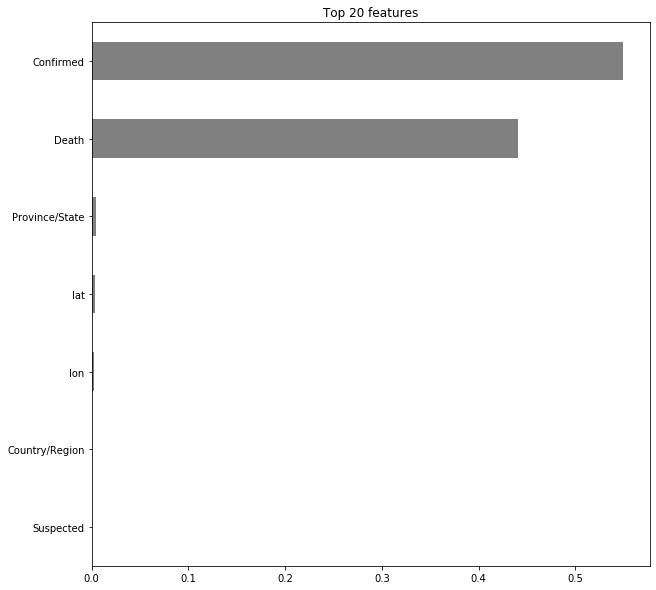

In [30]:
# Get feature importances
rf = rf_pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, x_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');